In [1]:
import matplotlib.pyplot as plt
from matplotlib import gridspec
import pandas as pd
import numpy as np
import h5py as h5

In [2]:
import energyflow as ef
from energyflow.archs import PFN
from energyflow.utils import data_split
import tensorflow as tf
import tensorflow_io as tfio

In [3]:
from IPython.display import display_html 
styles = [dict(selector="caption", 
    props=[("text-align", "center"),
    ("font-size", "120%"),
    ("color", 'black')])]    # the color value can not be None

image_df = pd.DataFrame({
    'Hit E' :[0], 'Hit X' :[1], 'Hit Y' :[2], 'Hit Depth':[3],
    'Layer 1 Z':[4], 'Layer 2 Z':[5]}, index=['Index'])

truth_df = pd.DataFrame({'Truth E':[0], 'Truth Theta':[1]},index=['Index'])

image_styler = image_df.style.set_table_attributes("style='display:inline'").set_caption('Calo Image Data')
truth_styler = truth_df.style.set_table_attributes("style='display:inline'").set_caption('Truth Particle Data')
display_html(image_styler._repr_html_()+truth_styler._repr_html_(), raw=True)

Calo Image Data 
 
 
   
 Hit E 
 Hit X 
 Hit Y 
 Hit Depth 
 Layer 1 Z 
 Layer 2 Z 
 
 
 
 
 Index 
 0 
 1 
 2 
 3 
 4 
 5 
 
 
 

 
 Truth Particle Data 
 
 
   
 Truth E 
 Truth Theta 
 
 
 
 
 Index 
 0 
 1

### Load the Data

In [4]:
filename = 'layered_with0s.hdf5'
h5_file = h5.File(filename,'r')
print(list(h5_file.keys()))
images = h5_file['calo_images']
truth = h5_file['truth']

print(images.shape)
print(truth.shape)
print(images.chunks) # [0] should be = batch_size
print(truth.chunks)


['calo_images', 'truth']
(4000000, 6, 2636)
(4000000, 2, 15)
(100, 6, 2636)
(100, 2, 15)


In [5]:
import h5py
import tensorflow as tf

class generator:
    def __init__(self, file):
        self.file = file

    def __call__(self):
        with h5py.File(self.file, 'r') as hf:
            for im in hf["train_img"]:
                yield im

In [6]:
X = images[0:100000]
Y = truth[0:100000,0,0]
#Y_Mean = np.nanmean(Y)
#Y_StDev = np.nanstd(Y)
#Y = (Y - Y_Mean)/Y_StDev
#print(type(X))

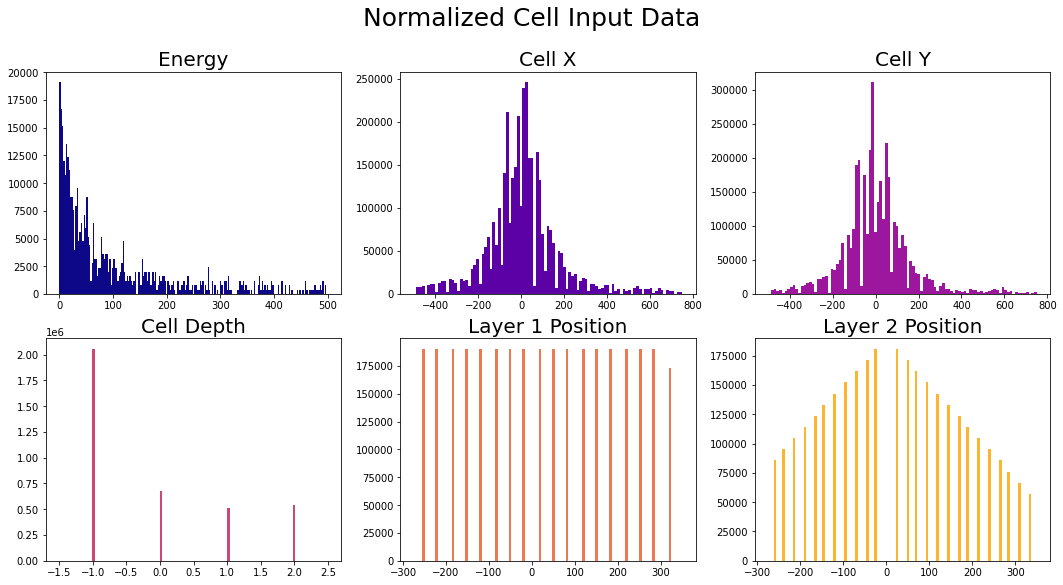

In [7]:
cm = plt.cm.get_cmap('plasma')
cell_vars = ["Energy","Cell X","Cell Y","Cell Depth","Layer 1 Position", "Layer 2 Position"]
bins = [np.linspace(0.01,500,200),np.linspace(-500,751,100),
        np.linspace(-500,751,100),np.linspace(-1.5,2.5,100),
        np.linspace(-275,350,100),np.linspace(-275,350,100)]
data=[]
fig = plt.figure(figsize=(18,9))
#plt.subplots_adjust(left=None, bottom=1, right=None, top=1.5, wspace=None, hspace=None)
for i in range(images.shape[1]):
    ax = plt.subplot(2, 3, i+1)
    data.insert(i,np.ravel(images[0:10000,i,:]))
    data[i] = data[i][data[i]!=0]
    plt.hist(data[i],bins=bins[i],color=cm(i/images.shape[1]))
    plt.title("%s"%(cell_vars[i]),fontsize=20)
    plt.suptitle("Normalized Cell Input Data",fontsize=25)
plt.savefig("Normalized_Cell_Data.pdf")
    #plt.xlabel('%s [Normalized]'%(cell_vars[i]),fontsize=15)


In [8]:
xi = np.arange(X.shape[0])
yi = np.arange(Y.shape[0])
(X_train, X_val, X_test,
Y_train, Y_val, Y_test) = data_split(X, Y, val=0.2, test=0.3,shuffle=True)

In [9]:
plt.hist(Y[Y_val],alpha=0.5,label="Validation Energy")
_ = plt.hist(Y[Y_test],alpha=0.5,label="Test Energy")
plt.legend()

IndexError: arrays used as indices must be of integer (or boolean) type

In [10]:
Phi_sizes, F_sizes = (100, 100, 128), (100, 100, 100)
output_act, output_dim = 'linear', 1
loss = 'mse' #mean-squared error
pfn = PFN(input_dim=X.shape[-1], Phi_sizes=Phi_sizes, F_sizes=F_sizes, 
          output_act=output_act, output_dim=output_dim, loss=loss, optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001))

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, None, 2636)  0           []                               
                                ]                                                                 
                                                                                                  
 tdist_0 (TimeDistributed)      (None, None, 100)    263700      ['input[0][0]']                  
                                                                                                  
 activation (Activation)        (None, None, 100)    0           ['tdist_0[0][0]']                
                                                                                                  
 tdist_1 (TimeDistributed)      (None, None, 100)    10100       ['activation[0][0]']         

2022-06-13 06:17:13.693812: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.2/lib64:/global/home/users/ftoralesacosta/user_pkg/usr/lib:/global/home/users/ftoralesacosta/user_pkg/usr/lib64:/lib:/lib64:/usr/lib:/usr/lib64
2022-06-13 06:17:13.693842: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2022-06-13 06:17:13.694151: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions

In [11]:
the_fit = pfn.fit(X_train, Y_train,
                  epochs=100,
                  batch_size=400,
                  validation_data=(X_val, Y_val),
                  verbose=1)

Epoch 1/100
125/125 [==============================] - 3s 22ms/step - loss: 5354.3843 - acc: 0.0000e+00 - val_loss: 759.3026 - val_acc: 0.0000e+00
Epoch 2/100
125/125 [==============================] - 2s 16ms/step - loss: 524.4940 - acc: 0.0000e+00 - val_loss: 377.0701 - val_acc: 0.0000e+00
Epoch 3/100
125/125 [==============================] - 2s 15ms/step - loss: 288.7048 - acc: 0.0000e+00 - val_loss: 232.5129 - val_acc: 0.0000e+00
Epoch 4/100
125/125 [==============================] - 2s 15ms/step - loss: 186.2339 - acc: 0.0000e+00 - val_loss: 162.3712 - val_acc: 0.0000e+00
Epoch 5/100
125/125 [==============================] - 2s 15ms/step - loss: 131.5899 - acc: 0.0000e+00 - val_loss: 122.7165 - val_acc: 0.0000e+00
Epoch 6/100
125/125 [==============================] - 2s 16ms/step - loss: 100.8028 - acc: 0.0000e+00 - val_loss: 97.2688 - val_acc: 0.0000e+00
Epoch 7/100
125/125 [==============================] - 2s 15ms/step - loss: 80.8633 - acc: 0.0000e+00 - val_loss: 81.9136 - 

In [13]:
pfn.layers
pfn.save("./energy_regression.h5")
mypreds = pfn.predict(X_test,batch_size=100)

300/300 [==============================] - 1s 3ms/step


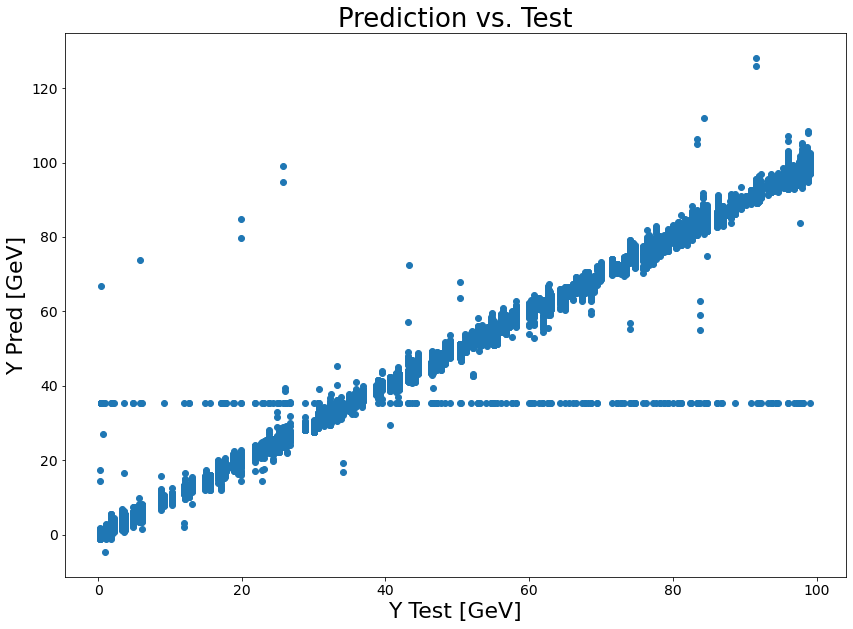

In [15]:
fig = plt.figure(figsize=(14,10))
plt.scatter(Y_test,mypreds)
plt.xlabel("Y Test [GeV]",fontsize=22)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel("Y Pred [GeV]",fontsize=22)
_ = plt.title("Prediction vs. Test",fontsize=26)
plt.savefig("Prediction_Test.pdf")
#FIXME: find indecies in mypreds where mypreds 50

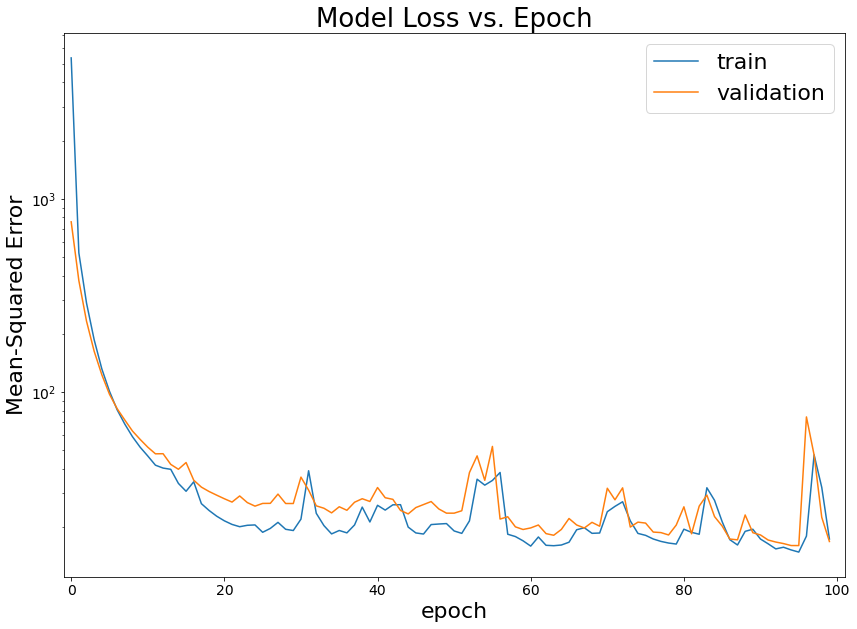

In [18]:
plt.figure(figsize=(14,10))
plt.plot(the_fit.history['loss'])
plt.plot(the_fit.history['val_loss'])
plt.title('Model Loss vs. Epoch',fontsize=26)
plt.ylabel('Mean-Squared Error',fontsize=22)
plt.yscale('log')
plt.xlabel('epoch',fontsize=22)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim([-1,101])
plt.legend(['train', 'validation'], loc='upper right',fontsize=22)
plt.show()

#print(Y_test)
#print(mypreds)

In [ ]:
#Loss as a function of layer

In [ ]:
#plot (F(x_0,z_0)-Etrue)^2 vs z.